[View in Colaboratory](https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/mnist.ipynb)

In [0]:
!pip3 install torch torchvision

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
batch_size=64
num_workers=1

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  img = np.array([img, img, img])
  return torch.from_numpy(img)

In [6]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


Processing...
Done!


In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

9


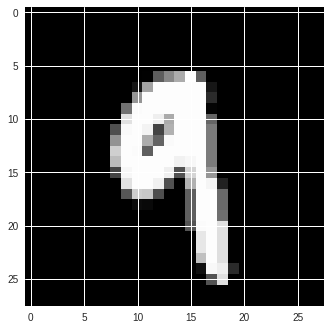

In [8]:
import matplotlib.pyplot as plt

trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
class MnistNET(nn.Module):
  def __init__(self):
    super(MnistNET, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
    x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)    
  

In [0]:
criterion = F.nll_loss

In [0]:
log_interval = 100
epochs = 10
use_cuda = True

In [0]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.5

In [0]:
model = MnistNET().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [17]:
for epoch in range(1, epochs+1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.660195
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.915756
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.992511
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.889326
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.459806
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.679200
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.385138
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.556799
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.236365

Test set: Average loss: 0.1757, Accuracy: 9462/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.522431
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.517711
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.215499
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.301063
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.294683
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.287156
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.399494
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.313966
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.367107
T

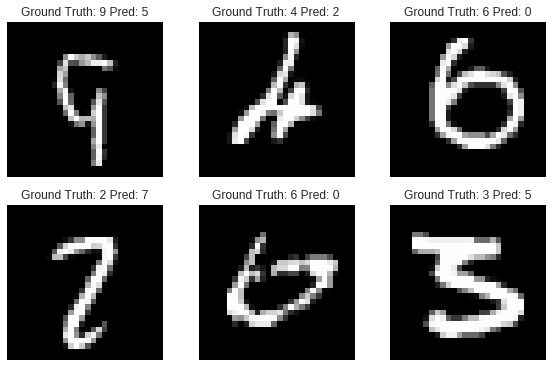

In [18]:
print_img = 6
fig = plt.figure()
for sample in test_set:
  inp = sample[0].unsqueeze(0)
  out = model(inp.to(device)).max(1)[1][0]
  if out != sample[1].to(device):

    plt.subplot(2,3,7 - print_img)
    plt.tight_layout()
    image = sample[0]
    image = image.numpy()
    image = image * 0.3081 + 0.1307
    plt.imshow(image.transpose(1,2,0), cmap='gray')
    plt.title("Ground Truth: {} Pred: {}".format(sample[1], out))
    plt.xticks([])
    plt.yticks([])
    
    print_img -= 1
    if print_img == 0: break
    


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "drive/My Drive"

In [0]:
import pickle

In [0]:
class Mnist_M(torch.utils.data.Dataset):
  
  def __init__(self, train=True, transform=None):
    
    self.train = train
    self.transform = transform
    
    with open('drive/My Drive/keras_mnistm.pkl', 'rb') as mnist_m:
      mnist_m_data = pickle.load(mnist_m, encoding='bytes')
    mnist_m_train_data = torch.ByteTensor(mnist_m_data[b'train'])
    mnist_m_test_data = torch.ByteTensor(mnist_m_data[b'test'])
    if train:
      mnist_m_train_labels = torchvision.datasets.MNIST(
          root='./data', train=True, download=True).train_labels
      self.mnist_m_set = list(zip(mnist_m_train_data, mnist_m_train_labels))
    else:
      mnist_m_test_labels = torchvision.datasets.MNIST(
          root='./data', train=False, download=True).test_labels
      self.mnist_m_set = list(zip(mnist_m_test_data, mnist_m_test_labels))
    self.len = len(self.mnist_m_set)
  
  def __len__(self):
    return self.len
  
  def __getitem__(self, index):
    label = self.mnist_m_set[index][1]
    sample = self.mnist_m_set[index][0].permute(2,0,1).float()
    sample = sample / 255
    
    if self.transform: 
      #sample = self.transform(sample)
      sample = (sample - 0.1307) / 0.3081
      
    return (sample, label)

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ])
mnist_m_train = Mnist_M(transform=mnist_m_transform)
mnist_m_test = Mnist_M(train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


tensor(2)


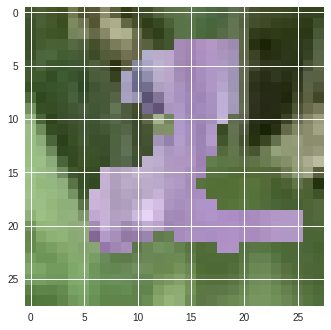

In [24]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [25]:
test(model, device, mnist_m_test_loader)


Test set: Average loss: 1.3184, Accuracy: 5647/10000 (56%)



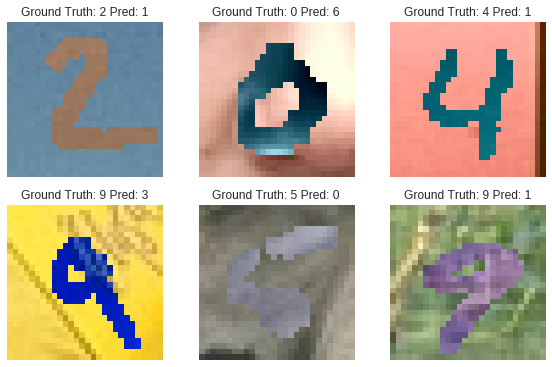

In [26]:
print_img = 6
fig = plt.figure()
for sample in mnist_m_test:
  inp = sample[0].unsqueeze(0)
  out = model(inp.to(device)).max(1)[1][0]
  if out != sample[1].to(device):

    plt.subplot(2,3,7 - print_img)
    plt.tight_layout()
    image = sample[0]
    image = image.numpy()
    image = image * 0.3081 + 0.1307
    plt.imshow(image.transpose(1,2,0), cmap='gray')
    plt.title("Ground Truth: {} Pred: {}".format(sample[1], out))
    plt.xticks([])
    plt.yticks([])
    
    print_img -= 1
    if print_img == 0: break

In [0]:
class Mnist_Ext(torch.utils.data.Dataset):
  def __init__(self, datasets):
    self.datasets = datasets
    self.lengths = [len(ds) for ds in datasets]
    self.offsets = np.cumsum(self.lengths)
    self.len = np.sum(self.lengths)
    
  def __len__(self):
    return self.len
  
  def __getitem__(self, index):
    for dset_num, dset_offset in enumerate(self.offsets):
      if index < dset_offset:
        index -= np.append([0], self.offsets)[dset_num]
        sample, label = self.datasets[dset_num][index]
        domain = torch.tensor(dset_num).float()
        return (sample, (label, domain))
  

In [0]:
mnist_ext_train = Mnist_Ext([train_set, mnist_m_train])
mnist_ext_test = Mnist_Ext([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)



tensor([3., 1.])


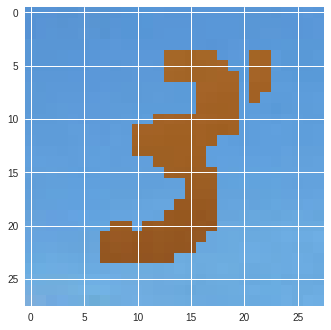

In [123]:
trainiter = iter(mnist_ext_train_loader)
images, labels = trainiter.next()
labels = torch.tensor(list(zip(labels[0], labels[1])))
printMnist3D(images[0])
print(labels[0])

In [0]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

def grad_reverse(x):
    return GradReverse.apply(x)
  

In [0]:
class MnistDomain(nn.Module):
  def __init__(self):
    super(MnistDomain, self).__init__()
    self.fc1 = nn.Linear(320, 100)
    self.fc2 = nn.Linear(100, 1)
  def forward(self, x):
    x = grad_reverse(x)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)
    

In [0]:
class MnistFeatureExtractor(nn.Module):
  def __init__(self):
    super(MnistFeatureExtractor, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
  def forward(self, x):
    x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
    x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    return x.view(-1, 320) 

In [0]:
class MnistClassPredictor(nn.Module):
  def __init__(self):
    super(MnistClassPredictor, self).__init__()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)    

In [0]:
criterion = F.nll_loss
criterion_domain = F.binary_cross_entropy

In [0]:
def trainWithDomain(model_f, model_c, model_d, device, train_loader_class, 
                    train_loader_domain, optim_f, optim_c, optim_d, epoch):
  model_f.train()
  model_c.train()
  model_d.train()
  domain_iter = iter(train_loader_domain)
  for batch_idx, (data, labels) in enumerate(train_loader):
    data = data.to(device)
    labels = labels.to(device)
    optim_f.zero_grad()
    optim_c.zero_grad()
    output = model_c(model_f(data))
    loss = criterion(output, labels)
    loss.backward()
    optim_f.step()
    optim_c.step()
    data, (_, domains) = domain_iter.next()
    data, domains = data.to(device), domains.unsqueeze(1).to(device)
    optim_f.zero_grad()
    optim_d.zero_grad()
    output = model_d(model_f(data))
    loss_domain = criterion_domain(output, domains)
    loss_domain.backward()
    optim_f.step()
    optim_d.step()
    
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def testWithDomain(model_f, model_c, device, test_loader):
  model_f.eval()
  model_c.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      labels, domains = target
      labels, domains = labels.to(device), domains.to(device)
      output = model_c(model_f(data))
      test_loss += criterion(output, labels, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(labels.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
model_f = MnistFeatureExtractor().to(device)
model_c = MnistClassPredictor().to(device)
model_d = MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum)


In [0]:
model_d(model_f(images[1].unsqueeze(0)))

In [121]:
for epoch in range(1, epochs+1):
  trainWithDomain(model_f, model_c, model_d, device,train_loader,
                  mnist_ext_train_loader, optim_f, optim_c, optim_d, epoch)
  testWithDomain(model_f, model_c, device, mnist_ext_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.514025
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.246221
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.277133
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.354218
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.295588
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.167516
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.636144
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.375276
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.313625
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.155462

Test set: Average loss: 0.6131, Accuracy: 16887/20000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.214132
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.277303
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.129505
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.187796
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.136601
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.253591
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.214731
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.257017
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.328507


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f05c62e27b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Test set: Average loss: 0.4881, Accuracy: 17291/20000 (86%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.131948
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.095247
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.202293
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.164696
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.220707
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.099386
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.078862
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.223349
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.230283
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.197928

Test set: Average loss: 0.4653, Accuracy: 17482/20000 (87%)



In [0]:
def testDomainModel(model_f, model_c, device, test_loader):
  model_f.eval()
  model_c.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, labels in test_loader:
      data, labels = data.to(device), labels.to(device)
      output = model_c(model_f(data))
      test_loss += criterion(output, labels, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(labels.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [125]:
testDomainModel(model_f, model_c, device, test_loader)


Test set: Average loss: 0.0597, Accuracy: 9810/10000 (98%)



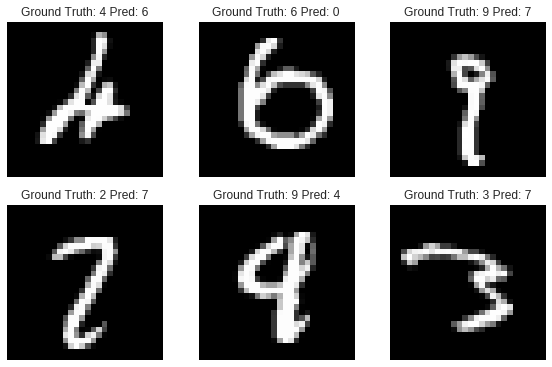

In [129]:
print_img = 6
fig = plt.figure()
for sample in test_set:
  inp = sample[0].unsqueeze(0)
  out = model_c(model_f(inp.to(device))).max(1)[1][0]
  if out != sample[1].to(device):

    plt.subplot(2,3,7 - print_img)
    plt.tight_layout()
    image = sample[0]
    image = image.numpy()
    image = image * 0.3081 + 0.1307
    plt.imshow(image.transpose(1,2,0), cmap='gray')
    plt.title("Ground Truth: {} Pred: {}".format(sample[1], out))
    plt.xticks([])
    plt.yticks([])
    
    print_img -= 1
    if print_img == 0: break
    

In [126]:
testDomainModel(model_f, model_c, device, mnist_m_test_loader)


Test set: Average loss: 0.8710, Accuracy: 7672/10000 (77%)



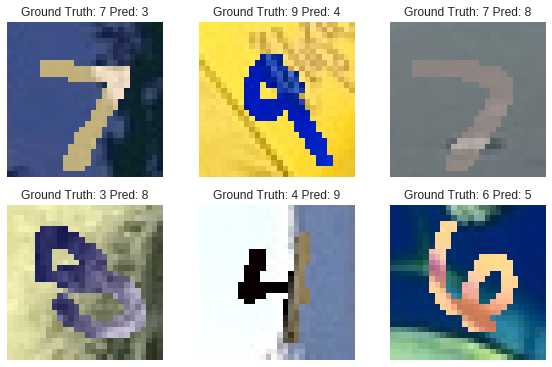

In [130]:
print_img = 6
fig = plt.figure()
for sample in mnist_m_test:
  inp = sample[0].unsqueeze(0)
  out = model_c(model_f(inp.to(device))).max(1)[1][0]
  if out != sample[1].to(device):

    plt.subplot(2,3,7 - print_img)
    plt.tight_layout()
    image = sample[0]
    image = image.numpy()
    image = image * 0.3081 + 0.1307
    plt.imshow(image.transpose(1,2,0), cmap='gray')
    plt.title("Ground Truth: {} Pred: {}".format(sample[1], out))
    plt.xticks([])
    plt.yticks([])
    
    print_img -= 1
    if print_img == 0: break